In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from math import sqrt


In [3]:
df=pd.read_csv('C:/Abdelouaheb/perso/Ph/time_series_analysis/data/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [19]:
# Understanding the data for time based train-test split
print(f'Start Date: {df.index.min()}')
print(f'End Date: {df.index.max()}')
print(f'Total Days: {len(df)}')

Start Date: 1985-01-01 00:00:00
End Date: 2018-01-01 00:00:00
Total Days: 397


In [21]:
# Check for missing values in the entire DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing Values in Each Column:")
print(missing_values)

Missing Values in Each Column:
IPG2211A2N    0
dtype: int64


In [6]:
df.head(2)

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720


In [5]:
df.tail(2)

,IPG2211A2N
DATE,
2017-12-01,114.7212
2018-01-01,129.4048


In [22]:
df.columns = ['value']
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [76]:
# Time based train-test splitting
test = df.loc['2015-08-01':]
train = df.loc[:'2015-08-01']

In [77]:
print(train.shape)
print("-"*50)
print(test.shape)

(368, 1)
--------------------------------------------------
(30, 1)


## ARIMA Model

<Figure size 432x288 with 0 Axes>

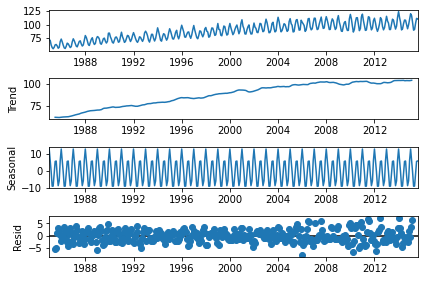

In [26]:
result = seasonal_decompose(train)

fig = plt.figure()  
fig = result.plot()
plt.show()

### Stationarity Test The Augmented Dickey-Fuller (ADF)

In [27]:
result=adfuller(train.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-2.2177366672247802
p-value:0.19987116175608627


ADF test. Here are the two hypotheses:

Null Hypothesis (H0): The null hypothesis assumes the presence of a unit root in the time series data, indicating that the data is non-stationary. 

Alternative Hypothesis (H1): The alternative hypothesis is the complement to the null hypothesis. It assumes the absence of a unit root, indicating that the data is stationary. 

In our case we can not reject H0 becasue p-value:0.19987116175608627 > 0.05

### Differentiation  

In [28]:
result=adfuller(train.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')


ADF Statistics:-6.9865733083977695
p-value:7.940503047364034e-10


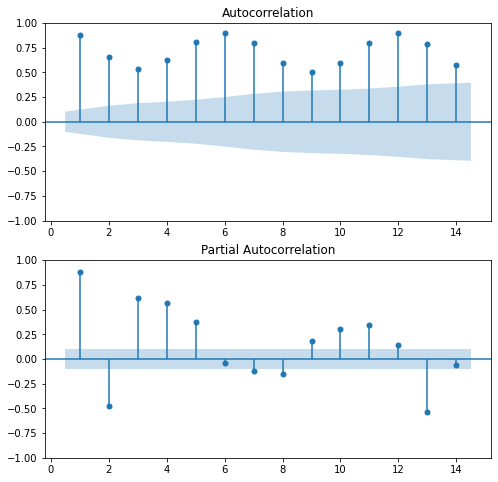

In [30]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(train,lags=14, zero=False, ax=ax1)
plot_pacf(train,lags=14, zero=False, ax=ax2)
plt.show()

### Choose model parameters ARIMA

In [33]:
results_arima=pm.auto_arima(train, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=False, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (6) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2407.180, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2527.135, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2471.677, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2406.464, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2525.204, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2313.827, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2282.181, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2238.163, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2238.122, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2250.261, Time=0.09 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.618 seconds


### Fit ARIMA model

In [ ]:
model_arima=SARIMAX(train,order=(0,1,3))
results_arima=model_arima.fit()

In [35]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  368
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -1121.131
Date:                Wed, 07 Feb 2024   AIC                           2250.261
Time:                        10:02:27   BIC                           2265.883
Sample:                    01-01-1985   HQIC                          2256.468
                         - 08-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1547      0.042      3.650      0.000       0.072       0.238
ma.L2         -0.4562      0.041    -10.998      0.000      -0.537      -0.375
ma.L3         -0.5491      0.046    -12.036      0.000      -0.639      -0.460
sigma2        26.2288      2.065     12.704      0.000      22.182      30.275
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.53   Prob(JB):                         0.43
Heteroskedasticity (H):               2.55   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Log Likelihood: The log-likelihood is a measure of how well a statistical model fits a set of observations. In this case, the log-likelihood value is -1121.131. A higher log-likelihood value indicates a better fit between the model and the data. In other words, the closer this value is to zero or a higher positive value, the better the model's fit.

AIC (Akaike Information Criterion): AIC is a measure of the relative quality of a statistical model for a given set of data. It balances the goodness of fit with the complexity of the model, penalizing models that are too complex. Lower AIC values indicate better models, with the lowest AIC suggesting the best trade-off between goodness of fit and model complexity. In this case, the AIC value is 2250.261.

BIC (Bayesian Information Criterion): BIC is similar to AIC but places a stronger penalty on models with more parameters. Like AIC, lower BIC values indicate better models, with the lowest BIC representing the best balance between model fit and complexity. The BIC value provided is 2265.883.

HQIC (Hannan-Quinn Information Criterion): HQIC is another criterion for model selection, similar to AIC and BIC. It also considers the model's goodness of fit and complexity but provides a different balance. As with AIC and BIC, lower HQIC values indicate better models, with the lowest HQIC suggesting the best model. The HQIC value given is 2256.468.

ma.L1 (Moving Average Lag 1):

Coefficient: 0.1547
Interpretation: For each unit increase in the error term at lag 1, we expect the current observation of electric production to increase by approximately 0.1547 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), indicating that the effect of the error term at lag 1 on the current observation is unlikely to be due to random chance.

ma.L2 (Moving Average Lag 2):

Coefficient: -0.4562
Interpretation: For each unit increase in the error term at lag 2, we expect the current observation of electric production to decrease by approximately 0.4562 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), suggesting that the effect of the error term at lag 2 on the current observation is unlikely to be due to random chance.

ma.L3 (Moving Average Lag 3):

Coefficient: -0.5491
Interpretation: For each unit increase in the error term at lag 3, we expect the current observation of electric production to decrease by approximately 0.5491 units, holding other variables constant.
Significance: The coefficient is statistically significant (p < 0.001), indicating that the effect of the error term at lag 3 on the current observation is unlikely to be due to random chance.

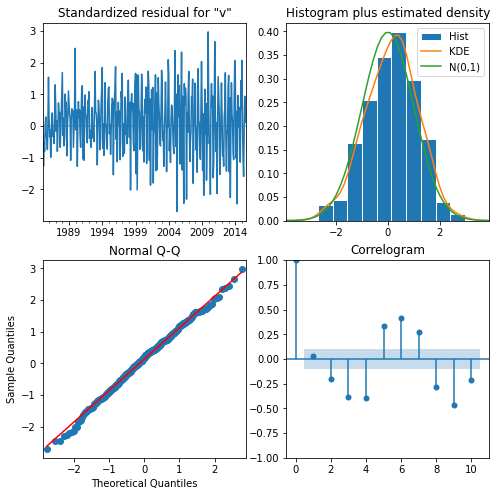

In [36]:
# Create the 4 diagostics plots
results_arima.plot_diagnostics(figsize=(8,8))
plt.show()

### Prediction using ARIMA

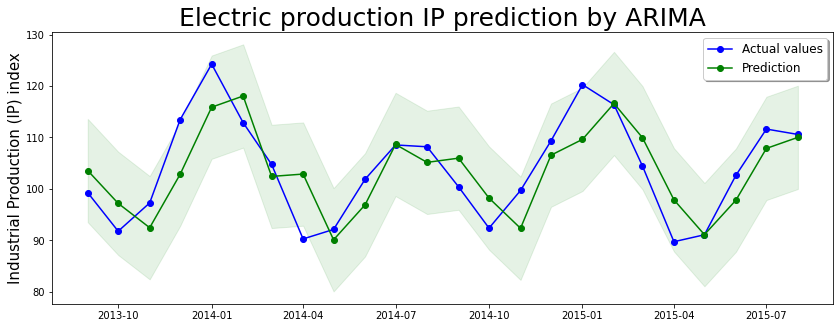

In [79]:
prediction_arima = results_arima.get_prediction(start=-24)
mean_prediction_arima=prediction_arima.predicted_mean
mean_prediction = mean_prediction_arima.rename("prediction")
confi_int_p_arima=prediction_arima.conf_int()
lower_limits_p_arima=confi_int_p_arima.iloc[:,0]
upper_limits_p_arima=confi_int_p_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by ARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction_arima[-24:].index, mean_prediction_arima[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction_arima[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

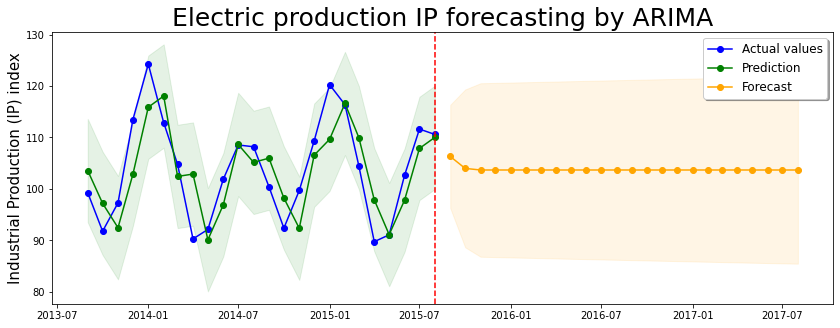

In [80]:
df_pred=train.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast_arima = results_arima.get_forecast(steps=24)
mean_forecast_arima=forecast_arima.predicted_mean
mean_forecast_arima = mean_forecast_arima.rename("prediction")
confi_int_f_arima=forecast_arima.conf_int()
lower_limits_f_arima=confi_int_f_arima.iloc[:,0]
upper_limits_f_arima=confi_int_f_arima.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p_arima, upper_limits_p_arima, alpha=0.1, color="green")

plt.plot(mean_forecast_arima[-24:].index,mean_forecast_arima[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast_arima[-24:].index, lower_limits_f_arima, upper_limits_f_arima, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [97]:
df_arima = pd.concat([mean_prediction_arima, mean_forecast_arima])

### SARIMA Model

In [40]:
results_sarimax=pm.auto_arima(train, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True,trend='ct')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1752.174, Time=1.21 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2202.815, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1798.165, Time=0.56 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=1909.077, Time=0.53 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=1980.482, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=1745.025, Time=0.79 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=2138.243, Time=0.67 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=1741.852, Time=1.78 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1751.010, Time=2.01 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=1784.762, Time=1.24 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=1799.205, Time=1.63 sec
 ARIMA(2,1,1)(2,1,0)[6]             : AIC=1766.886, Time=2.39 sec
 ARIMA(1,1,2)(2,1,0)[6]             : AIC=1761.889, Time=2.01 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=1808.621, Time=1.33 sec
 ARIMA(0,1,2)(2,1,0)[6]          

In [ ]:
model_sarimax=SARIMAX(train,order=(2,1,2),  seasonal_order=(1, 1, 0, 6))
results_sarimax=model_sarimax.fit()

In [44]:
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  368
Model:             SARIMAX(2, 1, 2)x(1, 1, [], 6)   Log Likelihood                -852.872
Date:                            Wed, 07 Feb 2024   AIC                           1717.743
Time:                                    10:26:12   BIC                           1741.077
Sample:                                01-01-1985   HQIC                          1727.020
                                     - 08-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3242      0.068     -4.773      0.000      -0.457      -0.191
ar.L2          0.4509      0.065      6.912      0.000       0.323       0.579
ma.L1         -0.0505      0.043     -1.186      0.236      -0.134       0.033
ma.L2         -0.9344      0.043    -21.622      0.000      -1.019      -0.850
ar.S.L6       -0.8215      0.027    -30.815      0.000      -0.874      -0.769
sigma2         6.3951      0.420     15.223      0.000       5.572       7.218
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.99   Prob(JB):                         0.02
Heteroskedasticity (H):               2.41   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ar.L1 (Autoregressive Lag 1):

Interpretation: When the value of the time series at lag 1 increases by one unit, the current value of the time series decreases by about 0.32 units.

ar.L2 (Autoregressive Lag 2):

Interpretation: When the value of the time series at lag 2 increases by one unit, the current value of the time series increases by about 0.45 units.

ma.L1 (Moving Average Lag 1):

Interpretation: The error term at lag 1 doesn't have a statistically significant effect on the current value of the time series. (The change in the current value due to the error term is not meaningful.)

ma.L2 (Moving Average Lag 2):

Interpretation: When the error term at lag 2 increases by one unit, the current value of the time series decreases by about 0.93 units.

ar.S.L6 (Seasonal Autoregressive Lag 6):

Interpretation: When the value of the time series at lag 6 (seasonal lag) increases by one unit, the current value of the time series decreases by about 0.82 units.
sigma2 (Residual Variance):

Interpretation: This value (about 6.40) represents the typical variability or spread of the errors around the model's predictions. It's an important measure for assessing the accuracy of the model's predictions.

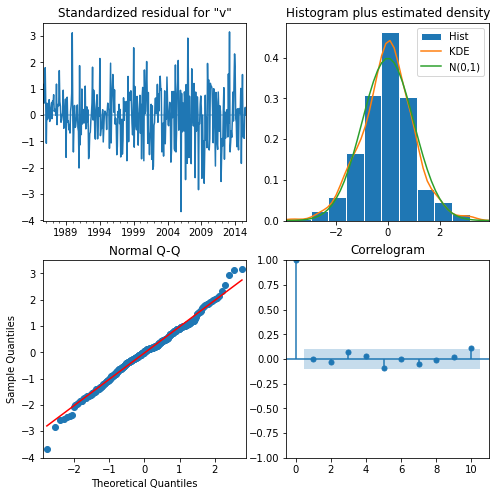

In [33]:
# Create the 4 diagostics plots
results_sarimax.plot_diagnostics(figsize=(8,8))
plt.show()

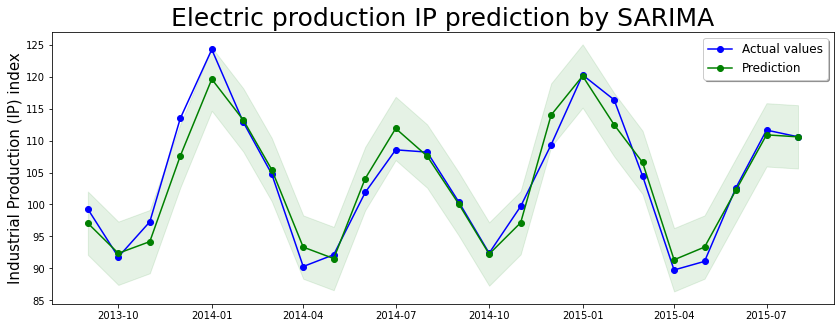

In [91]:
prediction = results_sarimax.get_prediction(start=-24)
mean_prediction=prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP prediction by SARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

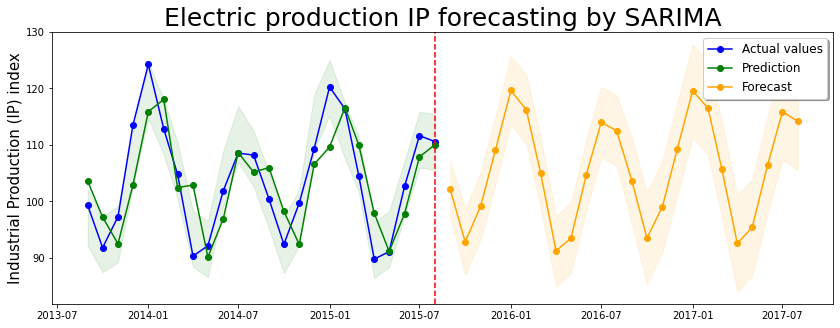

In [90]:
df_pred=train.iloc[-24:]
# Make ARIMA forecast of next 10 values
forecast = results_sarimax.get_forecast(steps=24)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by SARIMA", fontsize=25)

plt.plot(train[-24:].index,train[-24:].values, label='Actual values', color="blue", marker="o")

plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values,label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.plot(mean_forecast[-24:].index,mean_forecast[-24:].values, label='Forecast', color="orange", marker="o")
plt.fill_between(mean_forecast[-24:].index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(df_pred.iloc[-24:].index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [89]:
rmse_arima = sqrt(mean_squared_error(train[-24:].values,mean_prediction_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima:.2f}")

RMSE OF SARIMA MODEL : 5.98


In [92]:
rmse_arima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast_arima.values))
print(f"RMSE OF SARIMA MODEL : {rmse_arima1:.2f}")

RMSE OF SARIMA MODEL : 10.46


In [93]:
rmse_sarima = sqrt(mean_squared_error(train[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 2.53


In [96]:
rmse_sarima1 = sqrt(mean_squared_error(test[-24:].values,mean_forecast.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima1:.2f}")

RMSE OF SARIMA MODEL : 9.73


In [71]:
df_sarimax  = pd.concat([mean_prediction, mean_forecast])

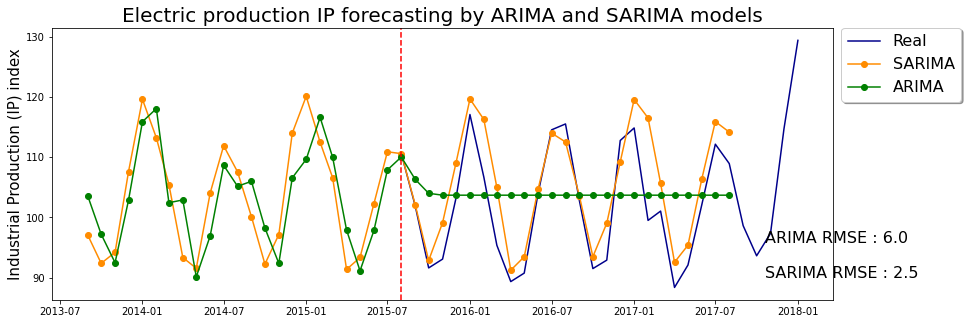

In [98]:
plt.figure(figsize=(14,5))
plt.title("Electric production IP forecasting by ARIMA and SARIMA models", fontsize=20)
plt.plot(test[-30:].index,test[-30:].values, color='darkblue', label='Real')
plt.plot(df_sarimax.index, df_sarimax.values, color='darkorange', label='SARIMA', marker='o')
plt.plot(df_arima.index, df_arima.values, color='green',label='ARIMA', marker='o')
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.legend(bbox_to_anchor=(1, 1.03),fontsize=16,fancybox=True, shadow=True, frameon=True)
text = 'ARIMA RMSE : {:.1f}\n\nSARIMA RMSE : {:.1f} '.format(rmse_arima,rmse_sarima)
plt.text(mean_forecast.index[-1] + pd.DateOffset(days=80),90,text, fontsize=16)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

In [160]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(df['value'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
new= model_fit.forecast(24)

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [162]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(df['value']),trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)
print(model_fit.params)

new= model_fit.forecast(24)

{'smoothing_level': 0.5, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 68.39752666666662, 'initial_trend': -1.1764048484848448, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_19780\3650223120.py:3: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=0.5, smoothing_slope=0.01, optimized=False)


In [164]:
smooth = pd.DataFrame(new, columns=['Column_Name'])